In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

import SessionTools.two_photon as st2p

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [13]:


def corr_w_lags(pp, shifts = [i for i in range(-11,12,1)]):
    '''
    '''
    
    dff = pp.calculate_zscored_F('rois', zscore=True, exp_detrend = True)[-1, :, :] 
    dff -= np.percentile(dff, 5, axis=-1, keepdims=True)
   
    # note smoothing conditions
    # dff = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(dff, 1, axis=-1),.5,axis=0, mode='wrap')
    
    
    # get PV and heading
    heading = -1*pp.voltage_recording_aligned[' Heading'].to_numpy()
    x_h, y_h = st2p.utilities.pol2cart(np.ones(heading.shape),heading)
    # _, heading_sm = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(x_h,3), sp.ndimage.gaussian_filter1d(y_h,3))

    x_f,y_f = st2p.utilities.pol2cart(dff ,np.linspace(-np.pi,np.pi,num=dff.shape[0])[:,np.newaxis])
    rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0)) # vector average
#     rho,phi = st2p.utilities.cart2pol(sp.ndimage.gaussian_filter1d(x_f.mean(axis=0),3), 
#                                       sp.ndimage.gaussian_filter1d(y_f.mean(axis=0),3))
    
    _,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))
    
    # calculate dPVA/dt and dHeading/dt
    dh = np.diff(np.unwrap(heading))
    dphi = np.diff(np.unwrap(phi))
    

    # get time bins for 10 frame shift in either direction
    volume_dt = np.diff(np.array(pp.metadata['frame_times'])[:,0])[0]
    shift_bins = np.arange(-10*volume_dt,10*volume_dt+1E-5,volume_dt)
    
    # calculate correlation at different lags
    times = volume_dt*np.array(shifts)
    xcorr = np.zeros((len(shifts),))
    
    for i, shift in enumerate(shifts):
        dphi_shift = np.roll(dphi,int(shift))
        xcorr[i] = np.corrcoef(dphi_shift, dh)[0,1]
        
    return xcorr, times 




    
# save vector for each fly, broken out by genotype & dark vs closed loop

In [14]:
common_times = np.arange(-10,11,1)*.1
print(common_times)

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]


# TBH RNAi

### R18B05 Gal4

In [22]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/R60D05LexA_jGCaMP7b_R18B05Gal4_TBHRNAi')
sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['gal4_line'] + '_' + row['rnai_line '] for _, row in sess_df.iterrows()]
figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/R60D05LexA_jGCaMP7b_R18B05Gal4_TBHRNAi/')

figfolder.mkdir(parents=True, exist_ok=True)
eg_folder = figfolder / 'sessions'
eg_folder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]
sess_df = sess_df.loc[~((sess_df['closed_loop']==0) * (sess_df['dark']==0))]



Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'closed_loop', 'dark',
       'rnai_line ', 'gal4_line', 'usable', 'fictrac_dat_file', 'notes'],
      dtype='object')


In [23]:
def el_rnai_epg_image_xcorr_loop(df):
    
    xcorr_arr = []
    # for each session
    for _,row in df.iterrows():
        if row['gal4_line']!='control':
            outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
            rnai = row['rnai_line ']
        else:
            outdir = pathlib.PurePath( basedir / 'gal4_control' / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
            rnai = 'gal4_control'


        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # calculate cross correlation
        xcorr, times = corr_w_lags(pp)
        # resample to across fly timing using linear splines
        spline = interp1d(times, xcorr, kind='linear')

        xcorr_arr.append(spline(common_times))

    return np.array(xcorr_arr)



cl_ctrl_mask = ((sess_df['rnai_line ']=='control') | (sess_df['gal4_line']=='control')) * (sess_df['closed_loop']>1)
xcorr_cl_ctrl = el_rnai_epg_image_xcorr_loop(sess_df.loc[cl_ctrl_mask])

dark_ctrl_mask = ((sess_df['rnai_line ']=='control') | (sess_df['gal4_line']=='control')) * (sess_df['closed_loop']==0)
xcorr_dark_ctrl = el_rnai_epg_image_xcorr_loop(sess_df.loc[dark_ctrl_mask])

cl_rnai_mask = (sess_df['rnai_line ']=='rnai_67968') * (sess_df['closed_loop']>1)
xcorr_cl_rnai = el_rnai_epg_image_xcorr_loop(sess_df.loc[cl_rnai_mask])

cl_rnai_mask = (sess_df['rnai_line ']=='rnai_67968') * (sess_df['closed_loop']==0)
xcorr_dark_rnai = el_rnai_epg_image_xcorr_loop(sess_df.loc[cl_rnai_mask])


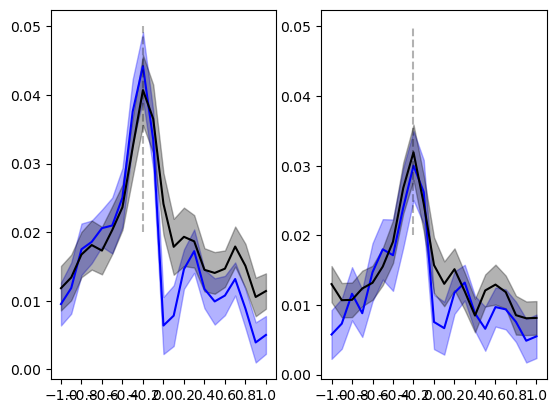

In [24]:
# xcorr_cl_ctrl.shape
fig, ax = plt.subplots(1,2)

mu, sem = xcorr_cl_ctrl.mean(axis=0), sp.stats.sem(xcorr_cl_ctrl, axis=0)
_ = ax[0].plot(common_times, mu, color='blue')
_ = ax[0].fill_between(common_times, mu-sem, mu+sem, color='blue', alpha = .3)

mu, sem = xcorr_dark_ctrl.mean(axis=0), sp.stats.sem(xcorr_dark_ctrl, axis=0)
_ = ax[0].plot(common_times, mu, color='black')
_ = ax[0].fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)

_ = ax[0].set_xticks(common_times[::2])
_ = ax[0].plot([-.2,-.2], [.02, .05], 'k--', alpha=.3)


mu, sem = xcorr_cl_rnai.mean(axis=0), sp.stats.sem(xcorr_cl_rnai, axis=0)
_ = ax[1].plot(common_times, mu, color='blue')
_ = ax[1].fill_between(common_times, mu-sem, mu+sem, color='blue', alpha = .3)

mu, sem = xcorr_dark_rnai.mean(axis=0), sp.stats.sem(xcorr_dark_rnai, axis=0)
_ = ax[1].plot(common_times, mu, color='black')
_ = ax[1].fill_between(common_times, mu-sem, mu+sem, color='black', alpha = .3)

_ = ax[1].set_xticks(common_times[::2])
_ = ax[1].plot([-.2,-.2], [.02, .05], 'k--', alpha=.3)

### EL split

In [25]:
basedir = pathlib.Path('/media/mplitt/SSD_storage/2P_scratch/EL_jGCaMP7b_TBHRNAi')

sess_df = pd.read_csv(basedir / 'sessions.csv')
print(sess_df.columns)
sess_df['fly_id'] = [row['date']+'_'+row['fly'] +'_' + row['gal4_line'] + '_' + row['rnai_line '] for _, row in sess_df.iterrows()]

figfolder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/EL_meetings/EL_jGCaMP7b_TBHRNAi/')
figfolder.mkdir(parents=True, exist_ok=True)

sess_df = sess_df.loc[sess_df['usable']==1]
sess_df = sess_df.loc[~((sess_df['closed_loop']==0) & (sess_df['dark']==0))]



Index(['date', 'fly', 'sess', 'fictrac_scan_num', 'closed_loop', 'dark',
       'rnai_line ', 'gal4_line', 'usable', 'fictrac_dat_file', 'notes'],
      dtype='object')


In [27]:
def el_rnai_image_xcorr_loop(df):
    
    xcorr_arr = []
    # for each session
    for _,row in df.iterrows():
        outdir = pathlib.PurePath( basedir / row['rnai_line '] / row['date'] / row['fly'] / row['sess'] / 'preprocess.pkl')
        rnai = row['rnai_line ']
        
        pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
        # calculate cross correlation
        xcorr, times = corr_w_lags(pp)
        # resample to across fly timing using linear splines
        spline = interp1d(times, xcorr, kind='linear')

        xcorr_arr.append(spline(common_times))

    return np.array(xcorr_arr)


        

In [28]:
cl_ctrl_mask = (sess_df['rnai_line ']=='control') * (sess_df['closed_loop']>1)
xcorr_cl_ctrl = el_rnai_image_xcorr_loop(sess_df.loc[cl_ctrl_mask])

dark_ctrl_mask 

# dark_ctrl_mask = ((sess_df['rnai_line ']=='control') | (sess_df['gal4_line']=='control')) * (sess_df['closed_loop']==0)
# xcorr_dark_ctrl = el_rnai_epg_image_xcorr_loop(sess_df.loc[dark_ctrl_mask])

# cl_rnai_mask = (sess_df['rnai_line ']=='rnai_67968') * (sess_df['closed_loop']>1)
# xcorr_cl_rnai = el_rnai_epg_image_xcorr_loop(sess_df.loc[cl_rnai_mask])

# cl_rnai_mask = (sess_df['rnai_line ']=='rnai_67968') * (sess_df['closed_loop']==0)
# xcorr_dark_rnai = el_rnai_epg_image_xcorr_loop(sess_df.loc[cl_rnai_mask])


In [ ]:
# repeat for all 7f data

In [ ]:
# repeat for jRGECO


In [ ]:
# repeat for GRAB-OA